<a href="https://colab.research.google.com/github/andri27-ts/1-Year-MachineLearning-Journey/blob/master/AE_AUXGAN_model_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x

In [2]:
!pip install procgen

     |████████████████████████████████| 36.5MB 81kB/s 
     |████████████████████████████████| 3.3MB 37.0MB/s 
     |████████████████████████████████| 22.2MB 137kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: imageio 2.4.1
    Uninstalling imageio-2.4.1:
      Successfully uninstalled imageio-2.4.1


In [0]:
import gym
from PIL import Image
from os.path import join
from os import listdir
import numpy as np
import random

import time
import tensorflow as tf
#from tensorflow.contrib.slim import fully_connected as fc
import matplotlib.pyplot as plt 
%matplotlib inline

In [0]:
def generate_images_from_procgen(env, num_images, folder='train'):
  n = 0
  while n < num_images:
    d = False
    o = env.reset()
    
    while not d:
      save_this = False

      a = np.random.randint(9)
      #a = env.action_space.sample()

      if np.random.rand() < 0.01:
        Image.fromarray(o).save(join(folder, '{}_{}_0.png'.format(n, a)))
        save_this = True

      o, r, d, _ = env.step(a)
      if not d:
        o, r, d, _ = env.step(a)

      if save_this:
        Image.fromarray(o).save(join(folder, '{}_{}_1.png'.format(n, a)))

      if not d:
        o, r, d, _ = env.step(a)
      if not d:
        o, r, d, _ = env.step(a)

      if save_this:
        Image.fromarray(o).save(join(folder, '{}_{}_2.png'.format(n, a)))
        n += 1        
        

## TRAIN DATASET
env = gym.make('procgen:procgen-coinrun-v0', num_levels=1000, 
                              start_level=0, distribution_mode='hard')
!mkdir train
generate_images_from_procgen(env, 30000,'train')

## TEST DATASET
env = gym.make('procgen:procgen-coinrun-v0', num_levels=100, 
                              start_level=99999, distribution_mode='hard')
!mkdir test
generate_images_from_procgen(env, 500,'test')

# New Section

In [0]:
class AEAuxGAN(object):

    def __init__(self, learning_rate=1e-4, batch_size=32, n_z=16, gamma=0.5):
        '''

        gamma : Hyperparameter that determine the weight of the auxiliar discriminator loss
        '''
        # Set hyperparameters
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z
        self.gamma = gamma

        # Build the graph
        self.build()

        # Initialize paramters
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    def variables_in_scope(self, scope):
        '''
        Retrieve all the variables in the scope 'scope'
        '''
        return tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope)

    def __encoder_model(self, x):
        ##########################################################################
        ################################  ENCODER  ###############################
        ##########################################################################

        with tf.variable_scope('encoder'):
          f1 = tf.layers.conv2d(x, filters=64, kernel_size=3, strides=2, padding='same', activation='relu') 
          f1 = tf.layers.BatchNormalization()(f1)
          f1a = tf.layers.conv2d(f1, filters=64, kernel_size=3, strides=2, padding='same', activation='relu') 
          f1a = tf.layers.BatchNormalization()(f1a)
          f2 = tf.layers.conv2d(f1a, filters=128, kernel_size=3, strides=2, padding='same', activation='relu') 
          f2 = tf.layers.BatchNormalization()(f2)
          #f2a = tf.layers.conv2d(f2, filters=128, kernel_size=3, strides=2, padding='same', activation='relu') 
          #f2a = tf.layers.BatchNormalization()(f2a)
          #f3 = tf.layers.conv2d(f2a, filters=256, kernel_size=3, strides=1, padding='same', activation='relu')
          #f3 = tf.layers.BatchNormalization()(f3)
          #print('f3:', f3.shape)

        return f2, f1, f1a
        
    def __decoder_skip_model(self, z, f1, f1a):
        ##########################################################################
        ################################  DECODER  ###############################
        ##########################################################################
        with tf.variable_scope('decoder'):

          #g2 = tf.layers.Conv2DTranspose(filters=256, kernel_size=3, strides=1, padding='same', activation='relu')(z)
          #g2 = tf.layers.BatchNormalization()(g2)
          #g2a = tf.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(z)
          #g2a = tf.layers.BatchNormalization()(g2a)
          g3 = tf.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(z)
          g3 = tf.layers.BatchNormalization()(g3)

          '''# Skip connection
          g3 = tf.math.add(g3, f1a)
          g3 = tf.nn.relu(g3)'''

          g3a = tf.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(g3)
          g3a = tf.layers.BatchNormalization()(g3a)

          # Skip connection
          print(f1.shape, f1a.shape, g3.shape, g3a.shape)
          g3a = tf.math.add(g3a, f1)
          g3a = tf.nn.relu(g3a)

          g4 = tf.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(g3a)
          g5 = tf.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=1, padding='same', activation='sigmoid')(g4)

        return g5 

    def __decoder_model(self, z):
        ##########################################################################
        ################################  DECODER  ###############################
        ##########################################################################
        with tf.variable_scope('decoder'):

          #g2 = tf.layers.Conv2DTranspose(filters=256, kernel_size=3, strides=1, padding='same', activation='relu')(z)
          #g2 = tf.layers.BatchNormalization()(g2)
          #g2a = tf.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(z)
          #g2a = tf.layers.BatchNormalization()(g2a)
          g3 = tf.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(z)
          g3 = tf.layers.BatchNormalization()(g3)
          g3a = tf.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(g3)
          g3a = tf.layers.BatchNormalization()(g3a)
          g4 = tf.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(g3a)
          g5 = tf.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=1, padding='same', activation='sigmoid')(g4)

        return g5 

    def __discriminator_model(self, x):
        ##########################################################################
        ##############################  CLASSIFIER  ##############################
        ##########################################################################
        
        f1 = tf.layers.conv2d(x, filters=32, kernel_size=3, strides=2, padding='valid', activation='relu') 
        f1 = tf.layers.BatchNormalization()(f1)
        f1a = tf.layers.conv2d(f1, filters=32, kernel_size=3, strides=2, padding='valid', activation='relu') 
        f1a = tf.layers.BatchNormalization()(f1a)
        f2 = tf.layers.conv2d(f1a, filters=64, kernel_size=3, strides=2, padding='valid', activation='relu') 
        f2 = tf.layers.BatchNormalization()(f2)
        f2a = tf.layers.conv2d(f2, filters=128, kernel_size=3, strides=2, padding='valid', activation='relu') 
        f2a = tf.layers.BatchNormalization()(f2a)
        #print('f2a shape:', f2a.shape)
        f3_fl = tf.layers.flatten(f2a)

        dns = tf.layers.dense(f3_fl, units=100, activation=tf.nn.relu)
        out = tf.layers.dense(dns, units=2, activation=tf.nn.softmax)

        return out

    # Build the netowrk and the loss functions
    def build(self):
        tf.reset_default_graph()        
        #self.fake_x = tf.placeholder(name='fake_x', dtype=tf.float32, shape=[None, w, h, 3])
        self.x = tf.placeholder(name='x', dtype=tf.float32, shape=[None, w, h, 6])
        self.a = tf.placeholder(name='action', dtype=tf.float32, shape=[None, w, h, 1])
        self.y = tf.placeholder(name='y', dtype=tf.float32, shape=[None, w, h, 3])
        
        ################################ AutoEncoder ################################

        with tf.variable_scope('autoencoder'):
          ## Encoder
          #a_2d = tf.broadcast_to(self.a/10, (None, w, h, 1))
          #print('Action 2D shape: ', a_2d.shape,'-- Try also to print')

          xa = tf.concat([self.x, self.a], axis=-1)
          print('After aconcat a+x: ', xa.shape,'-- Try also to print')

          enc_m, f1, f1a = self.__encoder_model(xa)
          print('Encoder output shape: ', enc_m.shape)
          ## Latent space
          '''enc_fl = tf.layers.flatten(enc_m)
          self.z = tf.layers.dense(enc_fl, units=self.n_z, activation=tf.nn.relu)
          g = tf.layers.dense(self.z, units=4*4*256, activation=tf.nn.relu)'''
          self.z = tf.layers.conv2d(enc_m, filters=128, kernel_size=3, strides=1, padding='same', activation='relu') 
          print('Hidden layer size:', tf.layers.flatten(self.z).shape)
          g = self.z
          
          ## Decoder
          #g = tf.reshape(g, shape=(-1,4,4,64), name='g_reshape')
          #self.pred_y = self.__decoder_model(g)
          self.pred_y = self.__decoder_skip_model(g, f1, f1a)
          #self.fake_x = self.pred_y
        
        # Loss
        y_ftt = tf.layers.flatten(self.y, name='y_flatten')
        pred_ftt = tf.layers.flatten(self.pred_y, name='y_pred_flatten')

        #decoder_loss = tf.compat.v1.losses.mean_squared_error(labels=x_real_ftt, predictions=x_fake_ftt) # V1
        #decoder_loss = tf.reduce_mean((y_ftt - pred_ftt)**2, axis=-1)
        # Frobenius MSE loss
        decoder_loss = tf.reduce_sum(tf.square(y_ftt - pred_ftt),axis=1) # NEW LOSS
        #decoder_loss = tf.reduce_mean(tf.math.abs(x_real_ftt - x_fake_ftt), axis=-1)
        # Nb: the following loss if symmetric for both predictions (hence I duplicated them on the first axis)
        #decoder_loss = tf.concat([decoder_loss, decoder_loss], axis=0)
        ## TODO: Needed?
        self.decoder_loss = tf.reduce_mean(decoder_loss)


        ################################ Classifier ################################
        
        '''with tf.variable_scope('discriminator'):
          self.pred_fake = self.__discriminator_model(self.fake_x)
        with tf.variable_scope('discriminator', reuse=True):
          self.pred_real = self.__discriminator_model(self.real_x)

        # TODO: pass batch size in a programatically way
        # fake: [1, 0] ## real: [0,1]
        self.target_labels = tf.concat(
            [tf.one_hot(np.zeros((int(self.batch_size))), depth=2), tf.one_hot(np.ones((int(self.batch_size))), depth=2)],
            axis=0)
        

        self.pred_labels = tf.concat([self.pred_fake, self.pred_real], axis=0)

        print('Target labels shape: {}, Pred labels shape: {} ## NB: should be equal dims'.format(
            self.target_labels.shape, self.pred_labels.shape))

        classifier_loss = tf.keras.backend.categorical_crossentropy(target=self.target_labels, 
                                                                    output=self.pred_labels)
        self.classifier_loss = tf.reduce_mean(classifier_loss)
        #classifier_loss = tf.keras.losses.BinaryCrossentropy()(y_true=self.y, y_pred=self.out)

        # TODO: Try: What happend if I backprop the gradient till the generator & use gradient ascent on those variables???
        # CLASSIFIER Optimizer
        print('Check discriminator trainable variables:', len(self.variables_in_scope('discriminator')), ' ## very small number compared with autoencoder')

        class_opt = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.class_train_op = class_opt.minimize(self.classifier_loss,
                                                 var_list=self.variables_in_scope('discriminator'))'''


        ################################ Full loss ################################


        ################# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        ################# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        ################# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # TODO: maybe I should place 2 here instead of 1. Reason being that I may sum 2 disciminative losses (the total is 2, not 1)
        # NB: TODO: Use 2 opt or 1?? I may train DISC & GEN jointly or separately...
        # NB: tf.math.minimum cut the value if the loss of the classifier is > 1. Otherwise, full_gen_loss will go to < 0
        #auxiliar_loss = tf.math.maximum(self.gamma*(1-classifier_loss), 0) 
        #auxiliar_loss = tf.stop_gradient(auxiliar_loss)
        
        full_gen_loss = decoder_loss #+ auxiliar_loss #tf.math.minimum(auxiliar_loss, decoder_loss*0.1)
        print('full_gen_loss shape:', full_gen_loss.shape, decoder_loss.shape)
        self.full_gen_loss = tf.reduce_mean(full_gen_loss)
        #self.auxiliar_loss = tf.reduce_mean(auxiliar_loss)
        #self.full_gen_loss = self.decoder_loss + self.auxiliar_loss # V1

        # GENERATOR Optimizer        
        print('Check autoencoder trainable variables:', len(self.variables_in_scope('autoencoder')))

        aut_opt = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.aut_train_op = aut_opt.minimize(self.full_gen_loss,
                                              var_list=self.variables_in_scope('autoencoder'))
        

        print('Check decoder trainable variables:', len(self.variables_in_scope('autoencoder/decoder')))

        gen_opt = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.gen_train_op = gen_opt.minimize(self.full_gen_loss,
                                              var_list=self.variables_in_scope('autoencoder/decoder'))

        self.losses = {
            'decoder': self.decoder_loss,
            #'classifier': self.classifier_loss,
            'full': self.full_gen_loss,
            #'auxiliary': self.auxiliar_loss
        }
        return

    def train_single_step_autoencoder(self, x, y, a):
        _, losses = self.sess.run(
            [self.aut_train_op, self.losses],
            feed_dict={self.x: x, self.a: a, self.y: y}
        )
        return losses

    def train_single_step_generator(self, x):
        _, losses = self.sess.run(
            [self.gen_train_op, self.losses],
            feed_dict={self.x: x}
        )
        return losses

    '''def train_single_step_classifier(self, x):
        _, losses = self.sess.run(
            [self.class_train_op, self.losses],
            feed_dict={self.real_x: x}
        )
        return losses'''

    def evaluate_autoencoder(self, x, y, a):
        return self.sess.run(self.losses, 
                             feed_dict={self.x: x, self.y: y, self.a: a} )

    def evaluate_classifier(self, x):
        return self.sess.run(self.losses, 
                             feed_dict={self.real_x: x} )

    def evaluate_classifier_accuracy(self, x):
        loss, targets, outs = self.sess.run([self.losses, self.target_labels, self.pred_labels], feed_dict={self.real_x: x} )

        res = []
        for t, o in zip(targets, outs):
          res.append(1 if np.argmax(t)==np.argmax(o) else 0)
        return loss, np.mean(res)*100

    def reconstructor(self, x, a):
        return self.sess.run(self.pred_y, 
                             feed_dict={self.x: x, self.a: a})
    
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.real_x: x})
        return z

In [0]:
def get_input_network(path_im):
  x1 = np.array(Image.open(join(path_im[:-5]+'0.png'))) / 255.
  x2 = np.array(Image.open(join(path_im[:-5]+'1.png'))) / 255.

  return np.concatenate([x1, x2], axis=-1)

def get_output_network(path_im):
  return np.array(Image.open(join(path_im[:-5]+'2.png'))) / 255.


def get_batch(batch_images_names, split_type):
    x_batch = np.array([get_input_network(join(split_type,im))
                        for im in batch_images_names])
            
    y_batch = np.array([get_output_network(join(split_type,im))
                        for im in batch_images_names])
            
    a_batch = np.array([np.ones((64, 64, 1))*np.round(int(im[-7:-6])/10,2)
                             for im in batch_images_names])
    return x_batch, y_batch, a_batch

In [0]:
def trainer(model_class, learning_rate=1e-4, 
            batch_size=64, num_epoch=100, n_z=16, 
            log_step=5, gamma=0, model=None,
            train_autoencoder=False,
            train_generator=False,
            train_classifier=False):
  
    # Create a model    

    if model is None:
      model = model_class(
          learning_rate=learning_rate, batch_size=batch_size, n_z=n_z, gamma=gamma)  
    
    # Training loop    
    for epoch in range(num_epoch):
        # TODO: Shuffle the batch every time
        start_time = time.time()

        # {?
        clas_train_name_images = train_name_images.copy()
        random.shuffle(clas_train_name_images)

        clas_train_name_images2 = train_name_images.copy()
        random.shuffle(clas_train_name_images2)
        # ?}

        random.shuffle(train_name_images)
        #print(train_name_images[0])
        
        train_losses = []
        # Run an epoch
        for iter in range(num_sample // batch_size):
            # Get a batch
            #batch = mnist.train.next_batch(batch_size)
            #print(Image.open(join('train',train_name_images[0])).convert('L').size)
            batch_train_images = train_name_images[iter*batch_size:iter*batch_size+batch_size]
            x_batch, y_batch, a_batch = get_batch(batch_train_images, 'train')
            
            # Execute the forward and backward pass 
            # Report computed loss
            if train_autoencoder:
              losses = model.train_single_step_autoencoder(x_batch, y_batch, a_batch)
              train_losses.append(losses)

            if train_generator:
              losses = model.train_single_step_generator(batch)
            
            # *1
            '''if train_classifier:
              batch = np.array([np.array(Image.open(join('train',im))) / 255.
                                for im in clas_train_name_images[iter*batch_size:iter*batch_size+batch_size]])
              losses = model.train_single_step_classifier(batch)

              # *2
              batch = np.array([np.array(Image.open(join('train',im))) / 255.
                                for im in clas_train_name_images2[iter*batch_size:iter*batch_size+batch_size]])
              losses = model.train_single_step_classifier(batch)'''

        # <--
        '''random.shuffle(train_name_images)
        for iter in range(num_sample // batch_size):
            batch = np.array([np.array(Image.open(join('train',im))) / 255.
                              for im in train_name_images[iter*batch_size:iter*batch_size+batch_size]])

            losses = model.train_single_step_classifier(batch)'''
        # -->

        end_time = time.time()

        # Log the loss
        if epoch % log_step == 0:
            log_str = '[Epoch {}] Losses: '.format(epoch)

            '''for k, v in losses.items():
                log_str += '{}: {:.4f}  '.format(k, v)'''

            log_str += " autoenc: {:.4f}".format(np.mean([l['decoder'] for l in train_losses]))
            log_str += '({:.4f} s/e)'.format(end_time - start_time)
            
            test_losses = []
            for iter in range(len(test_name_images) // batch_size):
              
              batch_test_images = test_name_images[iter*batch_size:iter*batch_size+batch_size]
              x_test_batch, y_test_batch, a_test_batch = get_batch(batch_test_images, 'test')

              test_loss = model.evaluate_autoencoder(x_test_batch, y_test_batch, a_test_batch)
              test_losses.append(test_loss)

            log_str += '  --  Test -- '
            log_str += 'AutoEnc loss: {:.4f}'.format(np.mean([l['decoder'] for l in test_losses]))

            #test_loss = model.evaluate_classifier(test_batch)
            #test_loss, test_accuracy = model.evaluate_classifier_accuracy(test_batch)
            #log_str += ' Classif loss: {:.4f} accuracy: {:.2f}'.format(test_loss['classifier'], test_accuracy)
            print(log_str)

                        
    print('Done!')
    return model

In [18]:
train_name_images = [f for f in listdir('train') if ('.png' in f) and ('next' not in f)]
test_name_images = [f for f in listdir('test') if ('.png' in f) and ('next' not in f)]

num_sample = len(train_name_images)
print('Num sample:', num_sample)
input_dim_d1, input_dim_d2 = Image.open(join('train', train_name_images[0])).size
#input_dim = input_dim_d1*input_dim_d2
input_dim = [64,64]
print('Input dim:', input_dim)

w = h = 64

Num sample: 1500
Input dim: [64, 64]


In [19]:
## NB: I'm still backprop trough the classifier and updating the autoencoder

generative_model = trainer(AEAuxGAN, 
                           num_epoch=100, 
                           learning_rate=2e-4, 
                           n_z=64, 
                           batch_size=128,
                           gamma=0.005, #previosuly: 0.02
                           log_step=10,
                           train_autoencoder=True,
                           train_generator=False,
                           train_classifier=False)


#[Epoch 25] decoder_loss: 0.0948  classifier_loss: 0.3668  full_loss: 0.2215  (70.4256 s/e)  --  Test AutoEnc loss: 0.0962  --  Test Classif loss: 0.3896

#[Epoch 285] Losses: decoder: 0.0200  classifier: 0.5703  full: 0.0286  auxiliary: 0.0086  (2.6953 s/e)  --  Test -- AutoEnc loss: 0.0330 Classif loss: 0.6311 accuracy: 75.00
#[Epoch 295] Losses: decoder: 0.0175  classifier: 0.5262  full: 0.0270  auxiliary: 0.0095  (2.6716 s/e)  --  Test -- AutoEnc loss: 0.0302 Classif loss: 0.5415 accuracy: 72.66
#[Epoch 295] Losses: decoder: 0.0137  classifier: 0.1283  full: 0.0313  auxiliary: 0.0176  (2.6281 s/e)  --  Test -- AutoEnc loss: 0.0290 Classif loss: 0.0746 accuracy: 98.44
# vs [Epoch 295] Losses: decoder: 0.0128  classifier: 0.6939  full: 0.0189  auxiliary: 0.0061  (1.7642 s/e)  --  Test -- AutoEnc loss: 0.0269 Classif loss: 0.6942 accuracy: 51.56

# n_z=256 [Epoch 190] Losses: decoder: 0.0031  classifier: 0.6987  full: 0.0046  auxiliary: 0.0015  (9.4539 s/e)  --  Test -- AutoEnc loss: 0.0042 Classif loss: 0.6981 accuracy: 49.22

# n_z=64 [Epoch 190] Losses: decoder: 0.0035  classifier: 0.6963  full: 0.0050  auxiliary: 0.0015  (9.2870 s/e)  --  Test -- AutoEnc loss: 0.0052 Classif loss: 0.6963 accuracy: 46.48



#[Epoch 190] Losses: decoder: 0.0021  classifier: 0.6962  full: 0.0036  auxiliary: 0.0015  (9.1061 s/e)  --  Test -- AutoEnc loss: 0.0026 Classif loss: 0.6963 accuracy: 50.00


## LAST: modified the loss function as MSE(pred*5 - correct*5) # to encourge exact predictions

#[Epoch 190] Losses: decoder: 0.0057  full: 0.0057  (12.3926 s/e)  --  Test -- AutoEnc loss: 0.0183


# [Epoch 90] Losses: decoder: 0.0042  full: 0.0042  (53.2127 s/e)  --  Test -- AutoEnc loss: 0.0065# 
# With skip-conn [Epoch 90] Losses: decoder: 0.0039  full: 0.0039  (51.3225 s/e)  --  Test -- AutoEnc loss: 0.0063
# 3x3 filter [Epoch 90] Losses: decoder: 0.0038  full: 0.0038  (50.6029 s/e)  --  Test -- AutoEnc loss: 0.0063

#[Epoch 50] Losses: decoder: 0.0034 (dec)  full: 0.0034  (82.4944 s/e)  --  Test -- AutoEnc loss: 0.0062

After aconcat a+x:  (?, 64, 64, 7) -- Try also to print
Encoder output shape:  (?, 8, 8, 128)
Hidden layer size: (?, 8192)
(?, 32, 32, 64) (?, 16, 16, 64) (?, 16, 16, 128) (?, 32, 32, 64)
full_gen_loss shape: (?,) (?,)
Check autoencoder trainable variables: 36
Check decoder trainable variables: 40


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[Epoch 0] Losses:  autoenc: 962.0611(2.4864 s/e)  --  Test -- AutoEnc loss: 791.9643
[Epoch 10] Losses:  autoenc: 214.2201(2.3560 s/e)  --  Test -- AutoEnc loss: 205.5392
[Epoch 20] Losses:  autoenc: 173.7223(2.4065 s/e)  --  Test -- AutoEnc loss: 168.2945
[Epoch 30] Losses:  autoenc: 156.7845(2.3792 s/e)  --  Test -- AutoEnc loss: 149.1494
[Epoch 40] Losses:  autoenc: 142.3325(2.4133 s/e)  --  Test -- AutoEnc loss: 137.7622
[Epoch 50] Losses:  autoenc: 134.3620(2.5154 s/e)  --  Test -- AutoEnc loss: 132.6501
[Epoch 60] Losses:  autoenc: 127.1274(2.4000 s/e)  --  Test -- AutoEnc loss: 126.1262
[Epoch 70] Losses:  autoenc: 124.1691(2.4124 s/e)  --  Test -- AutoEnc loss: 125.2059
[Epoch 80] Losses:  autoenc: 116.5243(2.3729 s/e)  --  Test -- AutoEnc loss: 121.9145
[Epoch 90] Losses:  autoenc: 110.8547(2.3666 s/e)  --  Test -- AutoEnc loss: 122.8703
Done!


In [0]:
import copy
gen_mod1 = copy.copy(generative_model)

In [0]:
gen_mod2 = trainer(AEAuxGAN,
                  model=gen_mod2,
                  num_epoch=200, 
                  learning_rate=2e-4, 
                  n_z=1024, 
                  batch_size=128,
                  gamma=0.005, #previosuly: 0.02
                  log_step=10,
                  train_autoencoder=False,
                  train_generator=True,
                  train_classifier=True)



---

TODO:
 - Use same encoder 4 (encoder & classifier?)



## TEST THE MODEL

In [0]:
def test_reconstruction(model, h=28, w=28, batch_size=30, batch_type='test'):
    # Test the trained model: reconstruction
    #batch = mnist.test.next_batch(batch_size)
    #test_batch = np.array([np.array(Image.open(join('test',im))) / 255.
    #                      for im in test_name_images])
    if batch_type == 'test':
      x_test_batch = np.array([get_input_network(join('test',im))
                          for im in test_name_images[:batch_size]])
      y_test_batch = np.array([get_output_network(join('test',im))
                          for im in test_name_images[:batch_size]])
      
      a_batch = np.array([np.ones((64, 64, 1))*int(im[-5:-4])/10 
                                for im in test_name_images[:batch_size]])
    elif batch_type == 'train':
      x_test_batch = np.array([get_input_network(join('train',im))
                          for im in train_name_images[:batch_size]])
      y_test_batch = np.array([get_output_network(join('train',im))
                          for im in train_name_images[:batch_size]])
      
      a_batch = np.array([np.ones((64, 64, 1))*int(im[-5:-4])/10 
                                for im in train_name_images[:batch_size]])
    else:
      print('Batch type not recognized')
      
    x_reconstructed = model.reconstructor(x_test_batch, a_batch)

    n = np.sqrt(batch_size).astype(np.int32)
    I_reconstructed = np.empty((h*n, 3*w*n, 3))
    for i in range(n):
        for j in range(n):
            x = np.concatenate(
                (x_reconstructed[i*n+j, :].reshape(h, w, 3), 
                 y_test_batch[i*n+j, :].reshape(h, w, 3),
                 x_test_batch[i*n+j, :, :, :3].reshape(h, w, 3))
                ,axis=1)
            I_reconstructed[i*h:(i+1)*h, j*3*w:(j+1)*3*w] = x

    plt.figure(figsize=(30, 50))
    plt.imshow(I_reconstructed, cmap='gray')

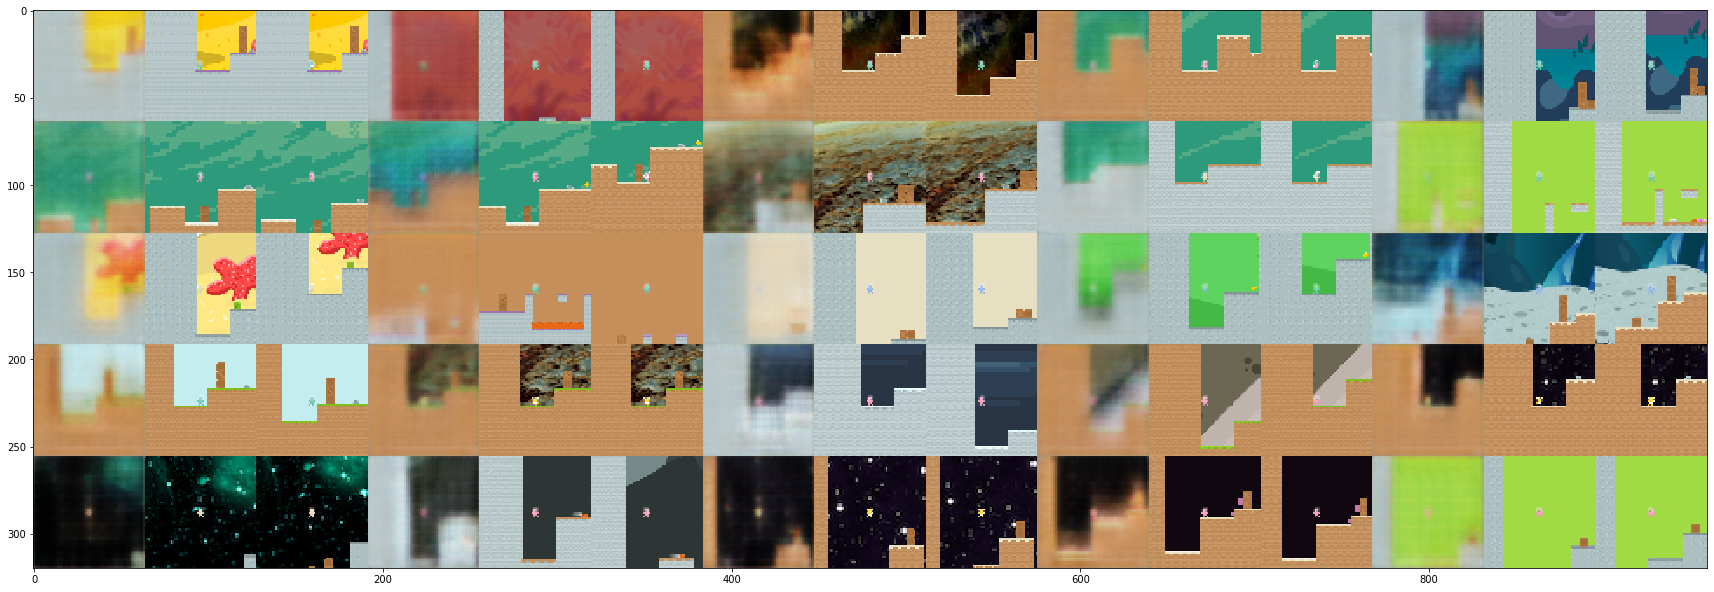

In [21]:
test_reconstruction(generative_model, 64, 64, batch_size=30, batch_type='train')

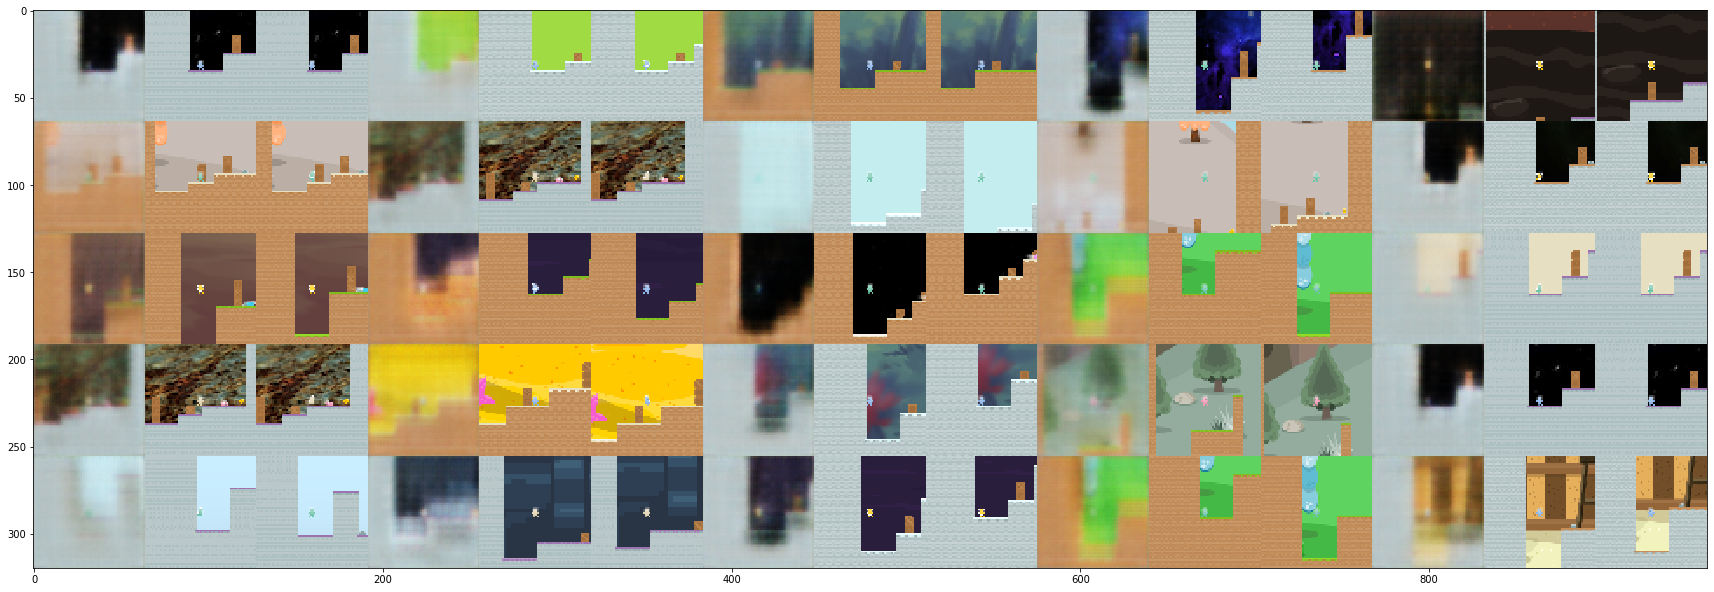

In [20]:
test_reconstruction(generative_model, 64, 64, batch_size=30, batch_type='test')

In [0]:
x_reconstructed = generative_model.reconstructor([np.array(Image.open(join('train',train_name_images[0]))) / 255.])

In [0]:
plt.imshow(x_reconstructed[0])